In [28]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import sys
import pprint
import random
import xml.etree.ElementTree as ET

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

We start off by shamelessly stealing the general structure of our solutiou out of the lab.

In [29]:
Vertex = namedtuple('Vertex', ['id', 'x', 'y', 'order'])

In [30]:
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

In [31]:
def fitness(vertices, distance, solution, lower_car_limit):
    solution_distance = 0
    # Punish using more cars than is possible
    used_cars = 0
    for x, y in zip(solution, solution[1:]):
        if x == solution[-1] and lower_car_limit >= used_cars:
            solution_distance += 1
        elif x == solution[-1]:
            solution_distance += 100
        solution_distance += distance(vertices[x], vertices[y])
    return solution_distance

In [32]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

In [33]:
def generate_solutions(vertices, pheromones, distance, N, ant_capacity, alpha=1, beta=3):
    
    def compute_prob(v1, v2, left_to_deliver, carrying=0):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        if left_to_deliver[v2] == 0 or carrying < left_to_deliver[v2]:
            ret = ret/2
        else:
            ret *= 2
        return ret if ret > 0.000001 else 0.000001
    
    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        left_to_deliver = 0
        left_to_deliver_list = []
        for vertex in vertices:
            left_to_deliver += vertex[3]
            left_to_deliver_list.append(vertex[3])
        available = list(range(pheromones_shape))
        carrying = ant_capacity
        # The depo vertex is always last
        solution = [pheromones_shape-1]
        available.remove(solution[0])
        while available:
            # Go back to pick up more cargo
            if carrying == 0:
                solution.append(pheromones_shape-1)
                carrying = ant_capacity
            # We fulfilled all orders, go straight home
            elif left_to_deliver == 0:
                solution.append(pheromones_shape-1)
                available.clear()
            else:
                probs = np.array(list(map(lambda x: compute_prob(solution[-1], x, carrying=carrying, left_to_deliver=left_to_deliver_list), available)))
                selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
                solution.append(selected)

                fulfilled_amount = min(carrying, left_to_deliver_list[selected])
                carrying -= fulfilled_amount
                left_to_deliver_list[selected] -= fulfilled_amount
                left_to_deliver -= fulfilled_amount

                # This can probably prevent some optimal solutions, but we may need to return to an unfulfilled order
                if left_to_deliver_list[selected] == 0 and selected != pheromones_shape - 1:
                    available.remove(selected)
                if not available:
                    if solution[-1] != pheromones_shape-1:
                        solution.append(pheromones_shape-1)
        yield solution

In [34]:
def ant_solver(vertices, distance, ants=10, ant_capacity=100, max_iterations=1000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')

    sols = []

    should_use_cars = 0
    for vertex in vertices:
            should_use_cars += vertex[3]
    should_use_cars = np.ceil(should_use_cars/ant_capacity)
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones=pheromones, distance=distance, N=ants, ant_capacity=ant_capacity, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x, should_use_cars), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
        sols.append(np.min(fits))
    plt.plot([i for i in range(0, len(sols))], sols)
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.title('Plot for {0} vertices'.format(len(vertices)))
    plt.show()
    return best_solution, pheromones

In [35]:
def read_xml_data(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    nodes = root.find('network').find('nodes')
    fleet = root.find('fleet')
    requests = root.find('requests')

    paired_requests = {}
    verticies = []
    depo = None

    for request in requests.findall('request'):
        node = int(request.get('node'))
        found = paired_requests.get(node, 0)
        paired_requests[node] = found+float(request.find('quantity').text)
    
    for node in nodes.findall('node'):
        type_of_node = int(node.get('type'))
        id = int(node.get('id'))
        
        if type_of_node == 1:
            verticies.append(Vertex(id, float(node.find('cx').text), float(node.find('cy').text), paired_requests.get(id, 0)))
        else:
            depo = Vertex(id, float(node.find('cx').text), float(node.find('cy').text), 0)
    
    capacity = float(fleet.find('vehicle_profile').find('capacity').text)
    return verticies, depo, capacity, paired_requests

In [36]:
def draw_result(vertices, pheromones, best_solution):
    lines = []
    colors = []
    for i, v1 in enumerate(vertices):
        for j, v2 in enumerate(vertices):
            lines.append([(v1.x, v1.y), (v2.x, v2.y)])
            colors.append(pheromones[i][j])

    lc = mc.LineCollection(lines, linewidths=np.array(colors))

    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.add_collection(lc)
    ax.autoscale()

    solution = best_solution

    cars_used = -1
    for i in best_solution:
        if i == best_solution[-1]:
            cars_used +=1

    # tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
    # solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

    print('Fitness: ', fitness(vertices, distance, solution, sys.maxsize))
    print('{0} cars used'.format(cars_used))

    solution_vertices = [vertices[i] for i in solution]
    pprint.pprint(solution_vertices)

    solution_lines = []
    for i, j in zip(solution, solution[1:]):
        solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])
    # solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])
    solutions_lc = mc.LineCollection(solution_lines, colors='red')
    ax.add_collection(solutions_lc)

   0, 1294.9810, 1830.3104, 2262.5249
   1, 1170.4795, 1477.9791, 1730.4351
   2, 1288.2926, 1418.8400, 1594.2863
   3, 1187.4317, 1378.9181, 1569.1923
   4, 1138.4099, 1382.9426, 1634.9207
   5, 1295.5666, 1430.9231, 1705.9830
   6, 1153.1270, 1307.3526, 1484.6481
   7, 1139.2756, 1307.9814, 1484.8322
   8, 1147.5161, 1324.5178, 1594.5435
   9, 1227.4644, 1347.1609, 1495.0731
  10, 1203.1737, 1339.6764, 1515.5388
  11, 1084.6049, 1289.2219, 1486.2732
  12, 1175.6245, 1284.7759, 1522.0556
  13, 1227.5322, 1321.3202, 1502.9606
  14, 1119.5580, 1321.4180, 1535.1079
  15, 1133.6785, 1269.2013, 1496.2963
  16, 1145.1379, 1257.4414, 1368.2135
  17, 1200.6215, 1280.0140, 1356.4270
  18, 1115.1858, 1271.3652, 1511.5938
  19, 1078.4692, 1235.8319, 1406.4698
  20, 1138.2215, 1284.3186, 1438.0247
  21, 1139.7002, 1257.9075, 1394.3636
  22, 1123.7474, 1284.9438, 1459.5604
  23, 1134.4999, 1326.6980, 1544.4847
  24, 1085.3013, 1296.1250, 1478.8937
  25, 1110.0970, 1241.2025, 1409.3306
  26, 961.57

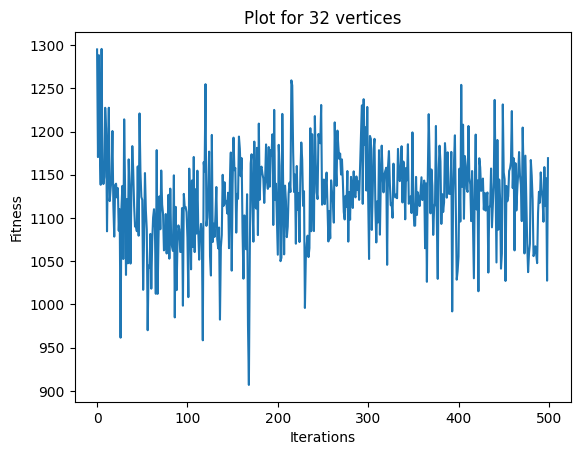

[31, 29, 25, 15, 11, 0, 6, 12, 31, 20, 30, 18, 16, 12, 23, 13, 26, 31, 19, 4, 24, 9, 14, 21, 8, 7, 10, 31, 5, 2, 1, 22, 27, 3, 10, 17, 28, 26, 31, 26, 31]
Min distance, Mean distance, Max distance


In [37]:
vertices, depo, capacity, paired_requests = read_xml_data('data/data_32.xml')
vertices.append(depo)
# Make the depo always the last vertex so that we don't have to rewrite the lab code too much
best_solution, pheromones = ant_solver(vertices = vertices, distance = distance, max_iterations=500, ant_capacity=capacity)
print(best_solution)
print('Min distance, Mean distance, Max distance')

Fitness:  906.9271685805036
5 cars used
[Vertex(id=1, x=82.0, y=76.0, order=0),
 Vertex(id=31, x=85.0, y=60.0, order=14.0),
 Vertex(id=27, x=80.0, y=55.0, order=2.0),
 Vertex(id=17, x=88.0, y=51.0, order=18.0),
 Vertex(id=13, x=98.0, y=52.0, order=21.0),
 Vertex(id=2, x=96.0, y=44.0, order=19.0),
 Vertex(id=8, x=84.0, y=39.0, order=16.0),
 Vertex(id=14, x=84.0, y=25.0, order=16.0),
 Vertex(id=1, x=82.0, y=76.0, order=0),
 Vertex(id=22, x=98.0, y=14.0, order=12.0),
 Vertex(id=32, x=98.0, y=5.0, order=9.0),
 Vertex(id=20, x=93.0, y=3.0, order=24.0),
 Vertex(id=18, x=91.0, y=2.0, order=19.0),
 Vertex(id=14, x=84.0, y=25.0, order=16.0),
 Vertex(id=25, x=61.0, y=62.0, order=24.0),
 Vertex(id=15, x=61.0, y=59.0, order=3.0),
 Vertex(id=28, x=57.0, y=69.0, order=20.0),
 Vertex(id=1, x=82.0, y=76.0, order=0),
 Vertex(id=21, x=50.0, y=93.0, order=8.0),
 Vertex(id=6, x=29.0, y=89.0, order=7.0),
 Vertex(id=26, x=9.0, y=97.0, order=24.0),
 Vertex(id=11, x=3.0, y=82.0, order=8.0),
 Vertex(id=16, x=1

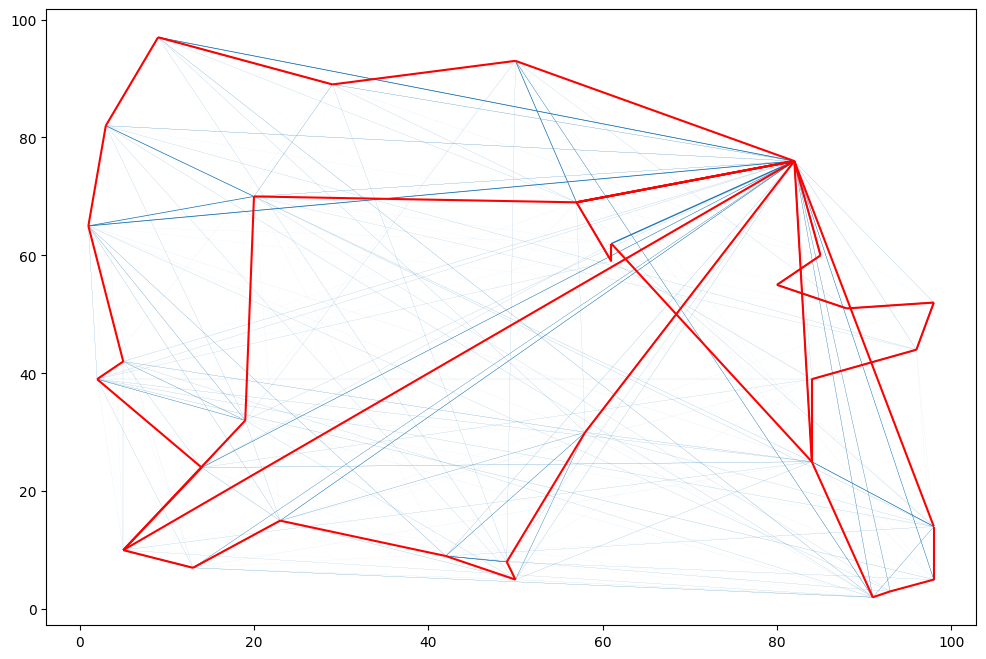

In [38]:
draw_result(vertices=vertices, pheromones=pheromones, best_solution=best_solution)

   0, 394.5094, 419.4006, 484.2111
   1, 352.0777, 393.4978, 433.6541
   2, 354.4636, 385.3401, 440.5819
   3, 341.6956, 382.5112, 432.4996
   4, 332.7149, 392.1315, 481.7383
   5, 338.4868, 387.7368, 451.1982
   6, 358.4867, 388.6307, 426.0791
   7, 347.7740, 382.3203, 416.1213
   8, 334.0432, 384.1866, 465.9718
   9, 341.7262, 380.8150, 443.0203
  10, 357.7194, 395.6498, 436.5629
  11, 347.4871, 405.1466, 460.5558
  12, 344.5212, 370.6115, 401.5159
  13, 328.6891, 362.9337, 386.9321
  14, 346.6387, 380.3058, 513.7663
  15, 343.3945, 373.4606, 415.6173
  16, 351.0169, 378.8759, 419.0795
  17, 345.7192, 375.3708, 413.4533
  18, 352.6364, 376.4179, 395.6379
  19, 353.5844, 375.9762, 420.6391
  20, 354.3548, 407.3076, 597.8555
  21, 354.3548, 370.6520, 411.0381
  22, 352.8486, 385.6410, 497.8858
  23, 354.3548, 390.0474, 470.9917
  24, 352.8486, 371.4701, 419.2865
  25, 362.3200, 385.2783, 432.2819
  26, 362.9017, 388.3323, 439.3391
  27, 357.9088, 377.9209, 411.4382
  28, 360.7604, 371.

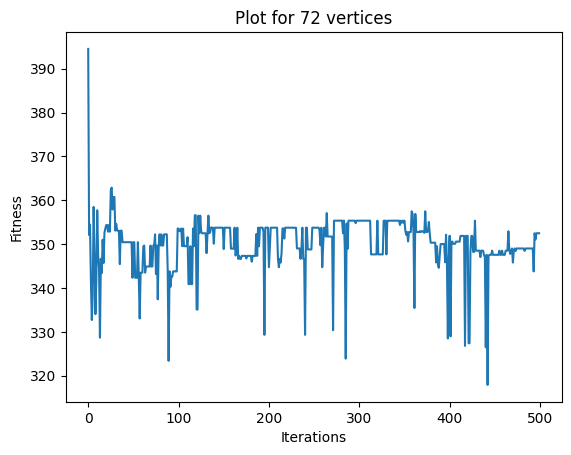

[71, 30, 31, 33, 32, 35, 34, 17, 0, 10, 71, 61, 65, 67, 38, 37, 36, 68, 66, 39, 69, 50, 48, 49, 46, 47, 44, 51, 41, 43, 52, 42, 45, 40, 56, 55, 71, 19, 28, 29, 20, 21, 27, 26, 24, 23, 25, 22, 54, 53, 55, 60, 59, 57, 58, 62, 64, 63, 10, 71, 10, 13, 18, 14, 1, 12, 16, 15, 11, 5, 70, 9, 2, 4, 7, 6, 3, 8, 71]
Min distance, Mean distance, Max distance


In [39]:
vertices, depo, capacity, paired_requests = read_xml_data('data/data_72.xml')
vertices.append(depo)
# Make the depo always the last vertex so that we don't have to rewrite the lab code too much
best_solution, pheromones = ant_solver(vertices = vertices, distance = distance, max_iterations=500, ant_capacity=capacity)
print(best_solution)
print('Min distance, Mean distance, Max distance')

Fitness:  317.91463499728445
4 cars used
[Vertex(id=1, x=0.0, y=0.0, order=0),
 Vertex(id=32, x=-6.0, y=1.0, order=883.0),
 Vertex(id=33, x=-6.0, y=2.0, order=1689.0),
 Vertex(id=35, x=-7.0, y=2.0, order=29.0),
 Vertex(id=34, x=-8.0, y=-2.0, order=10235.0),
 Vertex(id=37, x=-7.0, y=-2.0, order=450.0),
 Vertex(id=36, x=-7.0, y=-3.0, order=2894.0),
 Vertex(id=19, x=-9.0, y=-6.0, order=2832.0),
 Vertex(id=2, x=-12.0, y=-6.0, order=7063.0),
 Vertex(id=12, x=-11.0, y=-5.0, order=21611.0),
 Vertex(id=1, x=0.0, y=0.0, order=0),
 Vertex(id=63, x=-14.0, y=4.0, order=3934.0),
 Vertex(id=67, x=-16.0, y=7.0, order=2340.0),
 Vertex(id=69, x=-15.0, y=10.0, order=1264.0),
 Vertex(id=40, x=-12.0, y=10.0, order=496.0),
 Vertex(id=39, x=-20.0, y=13.0, order=207.0),
 Vertex(id=38, x=-20.0, y=12.0, order=411.0),
 Vertex(id=70, x=-20.0, y=10.0, order=806.0),
 Vertex(id=68, x=-16.0, y=8.0, order=754.0),
 Vertex(id=41, x=-20.0, y=15.0, order=1021.0),
 Vertex(id=71, x=-5.0, y=19.0, order=3665.0),
 Vertex(id=5

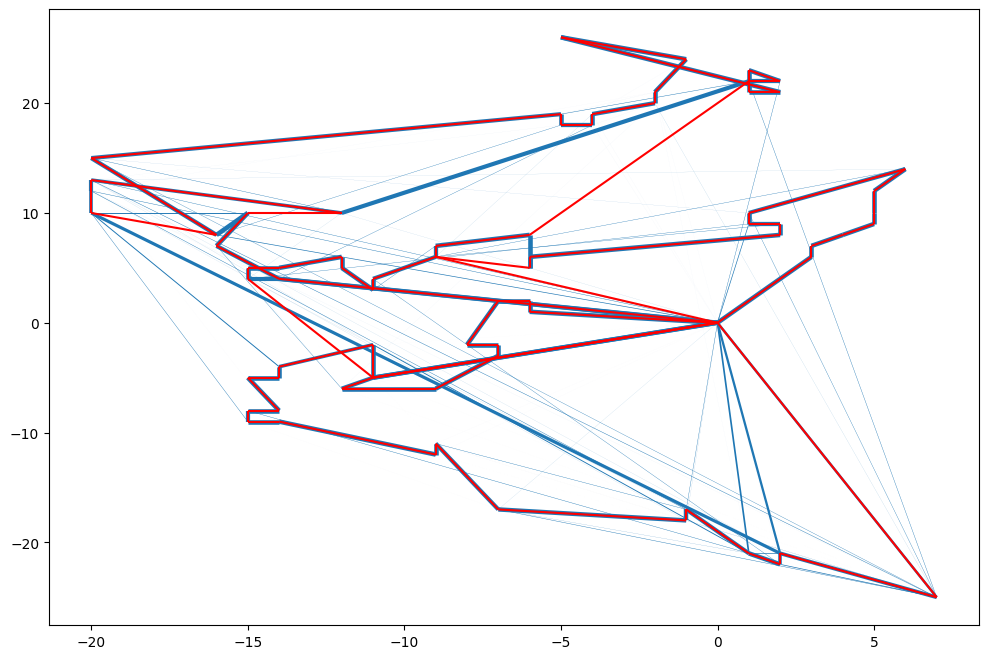

In [40]:
draw_result(vertices=vertices, pheromones=pheromones, best_solution=best_solution)

   0, 3395.3818, 3578.1303, 3800.1139
   1, 3020.8191, 3166.2639, 3336.8184
   2, 3050.1575, 3209.4591, 3314.1554
   3, 2992.1850, 3201.9704, 3449.3524
   4, 3035.5142, 3232.4428, 3510.8189
   5, 3156.7312, 3343.1809, 3610.2262
   6, 3111.5722, 3339.6186, 3491.3645
   7, 3237.8519, 3454.6258, 3630.2404
   8, 3130.9852, 3418.9015, 3598.6929
   9, 3162.6117, 3434.3460, 3626.1514
  10, 3137.4305, 3422.9644, 3659.1512
  11, 3170.7218, 3400.6273, 3723.5552
  12, 3113.9540, 3410.7426, 3658.6940
  13, 3185.2907, 3528.7808, 4004.0248
  14, 3327.2796, 3500.3927, 3653.4073
  15, 3145.4476, 3420.4350, 3765.0330
  16, 3193.5569, 3464.8229, 3817.4929
  17, 3303.5066, 3513.9653, 3839.7664
  18, 3293.0824, 3473.3006, 3740.4452
  19, 3290.1893, 3475.5535, 3725.0046
  20, 3291.5817, 3464.9851, 3686.1880
  21, 3224.6329, 3476.6704, 3775.9629
  22, 3226.9220, 3462.7042, 3641.7078
  23, 3152.6619, 3427.8956, 3651.5151
  24, 3128.4869, 3485.1881, 3735.5413
  25, 3209.0549, 3420.6155, 3791.0443
  26, 3203.2

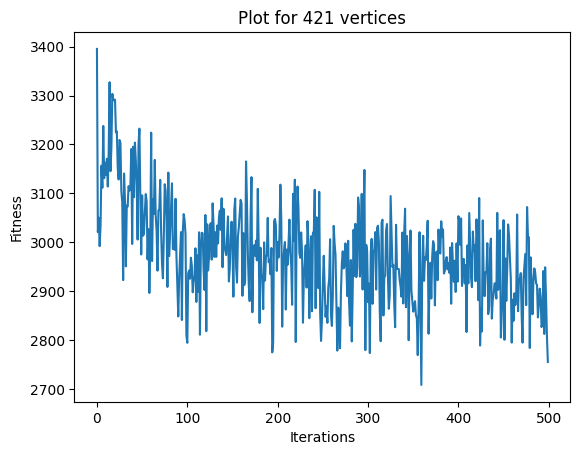

[420, 26, 27, 7, 92, 151, 211, 152, 127, 207, 266, 420, 122, 141, 90, 31, 32, 91, 150, 201, 182, 261, 210, 270, 420, 72, 17, 60, 113, 14, 15, 74, 173, 120, 132, 77, 18, 420, 45, 5, 52, 57, 112, 65, 54, 105, 165, 114, 55, 56, 51, 420, 39, 98, 149, 123, 156, 101, 102, 161, 216, 183, 269, 218, 420, 28, 2, 21, 30, 81, 62, 88, 33, 34, 93, 148, 208, 153, 420, 37, 4, 44, 49, 104, 64, 97, 46, 47, 48, 43, 42, 420, 19, 78, 6, 84, 143, 202, 253, 241, 260, 205, 206, 420, 29, 3, 36, 41, 96, 63, 89, 38, 40, 99, 158, 209, 159, 420, 58, 117, 172, 125, 225, 174, 115, 10, 116, 175, 176, 420, 85, 140, 121, 193, 142, 181, 200, 145, 86, 87, 67, 420, 83, 24, 313, 262, 203, 144, 66, 139, 198, 257, 312, 300, 420, 106, 157, 124, 164, 109, 50, 111, 170, 171, 70, 230, 420, 185, 232, 177, 178, 179, 71, 136, 195, 196, 255, 256, 420, 234, 285, 245, 292, 237, 238, 297, 352, 305, 345, 294, 235, 420, 12, 0, 53, 138, 79, 259, 318, 377, 317, 372, 360, 314, 420, 94, 35, 8, 95, 68, 155, 214, 273, 328, 302, 420, 166, 217, 

In [41]:
vertices, depo, capacity, paired_requests = read_xml_data('data/data_422.xml')
vertices.append(depo)
# Make the depo always the last vertex so that we don't have to rewrite the lab code too much
best_solution, pheromones = ant_solver(vertices = vertices, distance = distance, max_iterations=500, ant_capacity=capacity, ants=15)
print(best_solution)
print('Min distance, Mean distance, Max distance')

Fitness:  2708.391937987347
38 cars used
[Vertex(id=421, x=0.0, y=0.0, order=0),
 Vertex(id=27, x=1.4434, y=7.5, order=20.0),
 Vertex(id=28, x=0.7217, y=8.75, order=10.0),
 Vertex(id=8, x=0.0, y=10.0, order=40.0),
 Vertex(id=93, x=-0.9021, y=10.9375, order=10.0),
 Vertex(id=152, x=-2.2553, y=11.7187, order=20.0),
 Vertex(id=212, x=-2.8191, y=14.6484, order=20.0),
 Vertex(id=153, x=-1.1276, y=13.6719, order=10.0),
 Vertex(id=128, x=0.0, y=15.625, order=40.0),
 Vertex(id=208, x=1.4095, y=17.0898, order=10.0),
 Vertex(id=267, x=3.5239, y=18.3105, order=20.0),
 Vertex(id=421, x=0.0, y=0.0, order=0),
 Vertex(id=123, x=-4.5105, y=7.8125, order=40.0),
 Vertex(id=142, x=-3.1574, y=7.8125, order=10.0),
 Vertex(id=91, x=-2.7063, y=7.8125, order=10.0),
 Vertex(id=32, x=-1.4434, y=7.5, order=20.0),
 Vertex(id=33, x=-0.7217, y=8.75, order=10.0),
 Vertex(id=92, x=-1.8042, y=9.375, order=20.0),
 Vertex(id=151, x=-3.3829, y=9.7656, order=10.0),
 Vertex(id=202, x=-3.9467, y=9.7656, order=10.0),
 Vertex

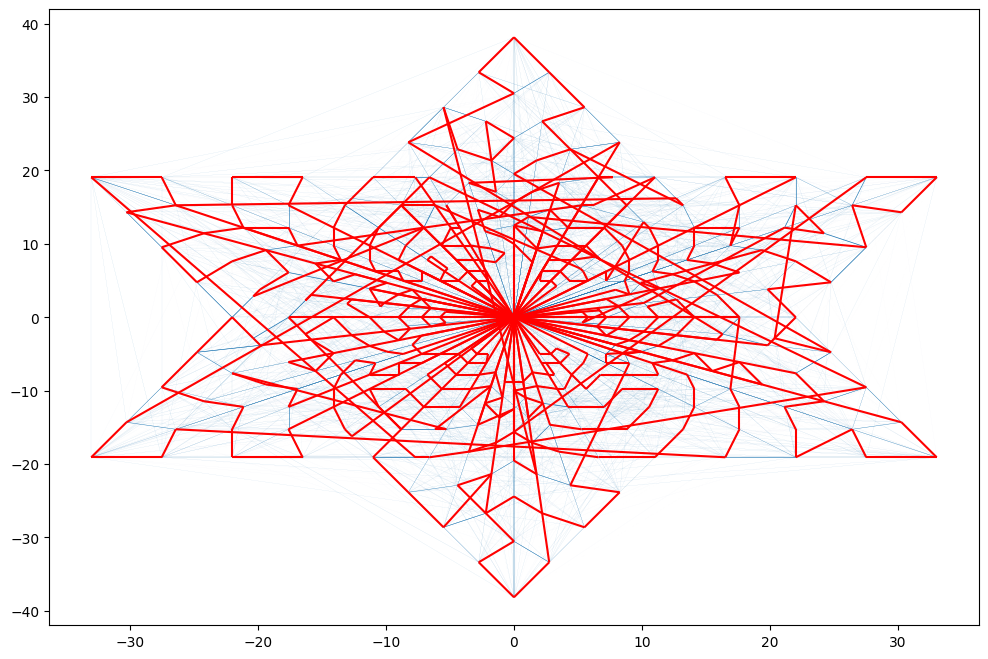

In [42]:
draw_result(vertices=vertices, pheromones=pheromones, best_solution=best_solution)